In [1]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
import numpy
import copy
import qiskit
from mitiq import zne
import mitiq
from mitiq.zne.scaling import fold_gates_from_left,fold_gates_at_random, fold_global,fold_gates_from_right
from mitiq.zne.inference import LinearFactory,RichardsonFactory,PolyFactory
import qiskit.providers.aer.noise as noise
import ipyparallel as ipp
from qiskit_nature.converters.second_quantization import QubitConverter
from qiskit.providers.aer import AerSimulator
from openfermion.linalg import givens_decomposition_square as givensRotns
from qiskit.opflow import I,X,Y,Z,StateFn,AbelianGrouper
from qiskit.opflow.primitive_ops import PauliSumOp
from qiskit_nature.mappers.second_quantization import JordanWignerMapper,ParityMapper
from qiskit_nature.problems.second_quantization.electronic.builders import fermionic_op_builder
from qiskit.quantum_info import Pauli
from qiskit.chemistry import FermionicOperator
from qiskit.aqua.operators.legacy import op_converter
from openfermion.circuits import slater_determinant_preparation_circuit
from qiskit import QuantumCircuit,execute,QuantumRegister,ClassicalRegister
from qiskit import Aer
from qiskit.circuit.random import random_circuit
from joblib import Parallel,delayed
from qiskit.aqua.operators import WeightedPauliOperator,Z2Symmetries
from qiskit.chemistry.components.variational_forms import UCCSD
import scipy

In [5]:
def countYgates(pauli_label):
    countYgates = sum(map(lambda x : 1 if 'Y' in x else 0, pauli_label))
    return countYgates
def egBandHamiltonianPartition(U):
    #Getting chemical Potential for Half-Filling
    with open('chem_pot_for_Half_Fill.txt','r') as f:
        lines=f.readlines()[1:]
        for line in lines:
            elems=line.split()
            if int(elems[0])==U:
                muHalf=float(elems[1]) #Chem Pot for a given Hubbard U
    #Getting the one body and two body interaction vertexes
    with open('v1e.dat','r') as f:
            lines=f.readlines()[1:]
            num_sites=4
            chem_pot=numpy.zeros((2*num_sites,2*num_sites))
            eg_h1_0=numpy.zeros((2*num_sites,2*num_sites))
            eg_h1_1=numpy.zeros((2*num_sites,2*num_sites))
            for line in lines:
                line=line.split()
                i,j=map(int,line[:2])
                val=float(line[2])
                if(i==j):
                    eg_h1_0[i,j]=eg_h1_0[i+num_sites,j+num_sites]=val
                else:
                    eg_h1_1[i,j]=eg_h1_1[i+num_sites,j+num_sites]=val
            for i in range(2*num_sites):
                chem_pot[i][i]=-muHalf
            eg_h1_0=eg_h1_0+chem_pot       
    with open('v2e.dat','r') as f:
        num_sites=4
        eg_h2_0=numpy.zeros((2*num_sites,2*num_sites,2*num_sites,2*num_sites))
        eg_h2_1=numpy.zeros((2*num_sites,2*num_sites,2*num_sites,2*num_sites))
        for line in f:
            if "#" in line:
                continue
            line = line.split()
            i,j,k,l = map(int, line[:4])
            val = float(line[4])
            if((i==j) and (k==l)):
                eg_h2_0[i,j,k,l] = eg_h2_0[i+num_sites,j+num_sites,k,l] = eg_h2_0[i,j,k+num_sites,l+num_sites] \
                = eg_h2_0[i+num_sites,j+num_sites,k+num_sites,l+num_sites] = 0.5*val  # convention with 0.5 factor included.
            else:
                eg_h2_0[i,j,k,l] = eg_h2_0[i+num_sites,j+num_sites,k+num_sites,l+num_sites] = 0.5*val  # convention with 0.5 factor included.
                eg_h2_1[i+num_sites,j+num_sites,k,l] = eg_h2_1[i,j,k+num_sites,l+num_sites] = 0.5*val
    return eg_h1_0,eg_h1_1,eg_h2_0,eg_h2_1
def Energy(params):
    circ=var_form_base.construct_circuit(parameters=params)
    state=execute(circ,Aer.get_backend('statevector_simulator'),shots=1024).result().get_statevector()
    E=(state.conj()@Hmat@state).real
    return E
def qubitOp(h1,h2):  
    fer_op=fermionic_op_builder.build_ferm_op_from_ints(h1,h2)
    qubit_conv = QubitConverter(ParityMapper(), two_qubit_reduction=True, z2symmetry_reduction="auto")
    qubit_op = qubit_conv.convert(fer_op, len(h1)//2)
    #mapper=JordanWignerMapper()
    #qubit_op=mapper.map(fer_op)
    return qubit_op 
def LRF_2_body_OD_terms(h2): #For 2 body off-diagonal terms
    def reshape_vec_to_mat(eigs):
        weight,vec1,vec2=eigs
        num_qubits=int(numpy.sqrt(vec1.shape[0]))
        L1=numpy.reshape(vec1,(num_qubits,num_qubits))
        L2=numpy.reshape(vec2,(num_qubits,num_qubits))
        return [numpy.sqrt(numpy.complex(weight))*L1,numpy.sqrt(numpy.complex(weight))*L2]
    #checksum  
    def higherRankRep(L):
        T=numpy.zeros((num_qubits,num_qubits,num_qubits,num_qubits))*1j
        for p in range(num_qubits):
            for q in range(num_qubits):
                for r in range(num_qubits):
                    for s in range(num_qubits):
                        T[p,q,r,s]=L[p,q]*L[r,s]
                        
        return T
    def get_givens_rotns(L):
        num_qubits=len(L)
        qubitH=qubitOp(numpy.zeros((8,8)),h2_X)
        num_qubits_red=qubitH.num_qubits
        H=qubitH.to_matrix()
        givens=givensRotns(L)[0]
        rotH=qubitH
        #print(givens,rotH)
        Ops=['IIIIIY','IIYIII']
        circ=QuantumCircuit(num_qubits_red)
        for l in range(len(givens)):
            rots=givens[l]
            for tup in rots:
                i,j,theta,phi=tup
                h1=numpy.zeros((num_qubits,num_qubits))*1j
                h1[i,j]=-1j
                h1[j,i]=1j
                qubit_h1=qubitOp(h1,numpy.zeros((num_qubits,num_qubits,num_qubits,num_qubits)))
                Op=PauliSumOp.from_list([('I'*num_qubits_red,1)])
                List=[(Ops[l],0.5)]
                for i in range(len(List)):
                    Op=PauliSumOp.from_list([('I'*num_qubits_red,numpy.cos(theta*List[i][1])),(List[i][0],-1j*numpy.sin(theta*List[i][1]))])@Op
                    circ=add_multiqubit_gate(List[i][0], theta*List[i][1], circ)  
                rotH=Op@rotH@Op.adjoint()
                rotH=rotH.reduce().reduce()
        return circ,rotH,qubitH
    #constructing Low rank factorization circuits
    #Super matrix rep of four rank tensor (NxNxNxN)->(N^2xN^2)
    num_qubits=len(h2)
    N2=num_qubits*num_qubits
    h2_pq_rs=numpy.reshape(h2,(N2,N2))
    #Diagonalize Super matrix
    #u,d,v=numpy.linalg.svd(h2_pq_rs,full_matrices=True)
    w,v=numpy.linalg.eigh(h2_pq_rs)
    #Build Cholesky vectors
    Larr=[]
    arr=[((w[i],v[:,i],v.conj().T[i])) for i in range(len(v)) if numpy.abs(w[i])>1e-4]
    Larr=list(map(reshape_vec_to_mat,arr))
    qc,rotH,qubit_h2=get_givens_rotns(Larr[0][0])
    return qc,rotH,qubit_h2

def add_multiqubit_gate(pauli_string, param, circuit):
    num_qubits=circuit.num_qubits
    qr=QuantumRegister(num_qubits,'q')
    if pauli_string == 'I'*num_qubits:
        gate = 1
        for j in range(len(pauli_string)):
            gate = numpy.kron(gate, Pauli('I').to_matrix())
        gate *= -1j * np.sin(param)
        gate += numpy.cos(param) * np.eye(2**num_qubits)
        circuit.unitary(gate, qr, label=pauli_string)
    else:
        qubits_to_act_on = []
        gate = 1
        for j in range(len(pauli_string)):
            if pauli_string[j] != 'I':
                gate=numpy.kron(Pauli(pauli_string[j]).to_matrix(),gate)
                qubits_to_act_on.append(num_qubits-j-1)
        gate *= (-1j * numpy.sin(param))
        gate += numpy.cos(param) * numpy.eye(2**len(qubits_to_act_on))
        List_regs=[qr[i] for i in qubits_to_act_on]#[::-1]
        Label=pauli_string+"\n{:0.02f}".format(param.real)
        circuit.unitary(gate, List_regs, label = Label)
    return circuit  

def get_givens_rotns(h):
        num_qubits=len(h)
        qubitH=qubitOp(h,numpy.zeros((num_qubits,num_qubits,num_qubits,num_qubits)))
        num_qubits_red=qubitH.num_qubits
        H=qubitH.to_matrix()
        w,v=numpy.linalg.eigh(h)
        givens=givensRotns(v.T)[0]
        rotH=qubitH
        circ=QuantumCircuit(num_qubits_red)
        for rots in givens:
            for tup in rots:
                i,j,theta,phi=tup
                h1=numpy.zeros((num_qubits,num_qubits))*1j
                h1[i,j]=-1j
                h1[j,i]=1j
                qubit_h1=qubitOp(h1,numpy.zeros((num_qubits,num_qubits,num_qubits,num_qubits)))
                List=qubit_h1.primitive.to_list()
                Op=PauliSumOp.from_list([('I'*num_qubits_red,1)])
                for i in range(len(List)):
                    Op=PauliSumOp.from_list([('I'*num_qubits_red,numpy.cos(theta*List[i][1])),(List[i][0],1j*numpy.sin(theta*List[i][1]))])@Op
                    circ=add_multiqubit_gate(List[i][0], theta*List[i][1], circ)
                rotH=Op@rotH@Op.adjoint()
                rotH=rotH.reduce().reduce()
        return circ,rotH,qubitH
    
def doubly_decomposed_form(h1_D,h1_X,h2_D,h2_X):

    #getting the givens rotation circuit and the rotated Hamiltonian for the one body terms
    circ_1_body,rotH_1_X,qubitH_1_X=get_givens_rotns(h1_X)
    #getting Cholesky vectors for two body off-diag terms
    circ_2_body,rotH_2_X,qubitH_2_X=LRF_2_body_OD_terms(h2_X)
    qubitH_D=qubitOp(h1_D,h2_D)
    circs_and_rotH_arr=[(circ_1_body,rotH_1_X,qubitH_1_X),(circ_2_body,rotH_2_X,qubitH_2_X),(qubitH_D)]
    return circs_and_rotH_arr

def expectation(h,circ):
    state=execute(circ,Aer.get_backend('statevector_simulator'),shots=1024).result().get_statevector()
    h_expec=state.conj()@h.to_matrix()@state
    return h_expec

def hamiltonian_estimation_in_doubly_decomposed_form_qasm(params,num_shots_arr=[2**18,2**18,2**18],measure_with_noise=False):
    def NoiseModel(p_meas=0.0,prob1=0.001,prob2=0.01):
        # Error probabilities
        #measurement error
        error_meas = noise.pauli_error([('X',p_meas), ('I', 1 - p_meas)])
        #prob_1 - 1-qubit gate
        #prob_2 - 2-qubit gate
        # Depolarizing quantum errors
        error_1 = noise.depolarizing_error(prob1, 1)
        error_2 = noise.depolarizing_error(prob2, 2)
        # Add errors to noise model
        noise_model = noise.NoiseModel()
        noise_model.add_all_qubit_quantum_error(error_meas, "measure")
        noise_model.add_all_qubit_quantum_error(error_1, ['u1', 'u2', 'u3'])
        noise_model.add_all_qubit_quantum_error(error_2, ['cx'])
        # Get basis gates from noise model
        basis_gates = noise_model.basis_gates
        return noise_model,basis_gates
    def Energy_Estimator_DD(input_vars):
        
        def getCounts(Input,noise_model=None,basis_gates=None):
            circ,num_shots=Input
            circ1=circ.copy()
            circ1.add_register(ClassicalRegister(6,'c'))
            circ1.measure([0,1,2,3,4,5],[0,1,2,3,4,5]) 
            job_sim = execute(circ1, AerSimulator(method='density_matrix'),shots=num_shots,basis_gates=basis_gates,noise_model=noise_model,had_transpiled=True) 
            result_sim = job_sim.result()
            #density_matrix = result_sim
            counts = result_sim.get_counts(circ1) 
            return counts#,density_matrix
        def estimate(PauliOp,counts):
            PauliString,coeff=PauliOp.primitive.to_list()[0]
            indexOfZs=numpy.where(numpy.array(list(PauliString))=='Z')[0]
            bitstrings,cnts=list(counts. keys()),list(counts.values())
            p=0
            count_valid=0
            for i in range(len(bitstrings)):
                bit_Str_to_Arr=numpy.array(list(bitstrings[i]))
                #flag1=1 if len(numpy.where(bit_Str_to_Arr=='1')[0])==4 else 0 #check number of electrons
                #flag2=1 if len(numpy.where(bit_Str_to_Arr[0:4]=='1')[0])==2 else 0 #check net spin
                #if ((flag1==1) and (flag2==1)):
                #count_valid=count_valid+cnts[i]
                counter_1=list(numpy.array(list(bitstrings[i]))[indexOfZs]).count('1')
                if counter_1%2==1:
                    p=p+cnts[i]
            p=p/sum(cnts)
            mean=(1-2*p)
            return mean*coeff.real
        def meanOp(PauliOp,counts):
            mean=0
            for i in range(len(PauliOp)):
                mean=mean+estimate(PauliOp[i],counts)
            return mean 
        def covariance(Op,i,j,counts):
            cov=estimate(Op[i]@Op[j],counts)-estimate(Op[i],counts)*estimate(Op[j],counts)
            return cov
        def covbtnOps(A,B,counts):
            corr=0
            for i in range(len(A)):
                for j in range(len(B)):
                    corr=corr+estimate(A[i]@B[j],counts)-estimate(A[i],counts)*estimate(B[j],counts)
            return corr        
        def variance(Op,counts):
            var=0
            cov_mat=numpy.zeros((len(Op),len(Op)))
            for i in range(len(Op)):
                for j in range(i,len(Op)):
                    if i==j:
                        mean=estimate(Op[i],counts)
                        coeff=Op[i].primitive.to_list()[0][1].real
                        cov_mat[i][j]=(coeff**2-mean**2)
                        var=var+(coeff**2-mean**2)
                    elif i!=j:
                        var=var+2*covariance(Op,i,j,counts)
                        cov_mat[i][j]=cov_mat[j][i]=covariance(Op,i,j,counts)
            return var
        def OpErr(data):
            Op,counts=data
            var=variance(Op,counts)
            err=numpy.sqrt(var/sum(counts.values()))
            return err.real
        if len(input_vars)==5:
            circ,Op,num_shots,noise_model,basis_gates=input_vars
            counts_Arr=getCounts((circ,num_shots),noise_model,basis_gates)
            m1=meanOp(Op,counts_Arr)
            err1=OpErr((Op,counts_Arr))
        else:
            circ,Op,num_shots=input_vars
            counts_Arr=getCounts((circ,num_shots))
            m1=meanOp(Op,counts_Arr)
            err1=OpErr((Op,counts_Arr))
        return m1,err1
    #params,num_shots_arr=input_vars
    ansatz_circ=var_form_base.construct_circuit(params)
    circ_rot_Arr=[ansatz_circ.copy(),ansatz_circ.copy(),ansatz_circ.copy()]
    noise_model,basis_gates=NoiseModel()
    h_part_expectation_arr=[]
    circ_rot_Arr[0]=circ_rot_Arr[0]+circs_and_rotH[0][0]
    circ_rot_Arr[1]=circ_rot_Arr[1]+circs_and_rotH[1][0]
#     #compile circuits
#     circ_rot_Arr[0] = qiskit.transpile(circ_rot_Arr[0],basis_gates=["u1", "u2", "u3", "cx"])
#     circ_rot_Arr[1] = qiskit.transpile(circ_rot_Arr[1],basis_gates=["u1", "u2", "u3", "cx"])
#     circ_rot_Arr[2] = qiskit.transpile(circ_rot_Arr[2],basis_gates=["u1", "u2", "u3", "cx"])
    #Estimate from statistics
    if measure_with_noise:
        data_arr=[(circ_rot_Arr[0],circs_and_rotH[0][1],num_shots_arr[0],noise_model,basis_gates),
                  (circ_rot_Arr[1],circs_and_rotH[1][1],num_shots_arr[1],noise_model,basis_gates),
                  (circ_rot_Arr[2],circs_and_rotH[2],num_shots_arr[2],noise_model,basis_gates)]
    else:
        data_arr=[(circ_rot_Arr[0],circs_and_rotH[0][1],num_shots_arr[0]),
                  (circ_rot_Arr[1],circs_and_rotH[1][1],num_shots_arr[1]),
                  (circ_rot_Arr[2],circs_and_rotH[2],num_shots_arr[2])]
    results=Parallel(n_jobs=6,verbose=2)(delayed(Energy_Estimator_DD)(data_arr[i]) for i in range(len(data_arr)))
    m1,err1=results[0][0],results[0][1]
    m2,err2=results[1][0],results[1][1]
    m3,err3=results[2][0],results[2][1]
    #print("mean:",m1+m2+m3,"err:",err1+err2+err3)
    return m1+m2+m3
def Energy(params):
    circ=var_form_base.construct_circuit(parameters=params)
    state=numpy.array(list(execute(circ,Aer.get_backend('statevector_simulator'),shots=1024).result().get_statevector()))
    E=(state.conj()@Hmat@state).real
    return E

In [6]:
#Adadelta with Statevector
backend=Aer.get_backend('statevector_simulator')
def AdaDelta_qasm(params,runs=20,num_shots_arr=[2**16,2**16,2**16],save_opt_steps=False):
    string_shots_label=','.join([str(shots) for shots in num_shots_arr])
    v=numpy.zeros((len(params)))*0.0
    delta=numpy.zeros((len(params)))*0.0
    beta=0.9
    directions= numpy.arange(len(params))
    delta=0
    E_arr=[]
    ind=0
    eps=numpy.array([1e-10]*len(params))
    def StochGrad(params,directions,num_shots_arr):
        def Energy_Estimator_DD(input_vars):
        
            def getCounts(Input):
                circ,num_shots=Input
                circ1=circ.copy()
                circ1.add_register(ClassicalRegister(6,'c'))
                circ1.measure([0,1,2,3,4,5],[0,1,2,3,4,5]) 
                job_sim = execute(circ1, AerSimulator(method='density_matrix'),shots=num_shots) 
                result_sim = job_sim.result()
                counts = result_sim.get_counts(circ1) 
                return counts
            def estimate(PauliOp,counts):
                PauliString,coeff=PauliOp.primitive.to_list()[0]
                indexOfZs=numpy.where(numpy.array(list(PauliString))=='Z')[0]
                bitstrings,cnts=list(counts. keys()),list(counts.values())
                p=0
                count_valid=0
                for i in range(len(bitstrings)):
                    bit_Str_to_Arr=numpy.array(list(bitstrings[i]))
                    counter_1=list(numpy.array(list(bitstrings[i]))[indexOfZs]).count('1')
                    if counter_1%2==1:
                        p=p+cnts[i]
                p=p/sum(cnts)
                mean=(1-2*p)
                return mean*coeff.real
            def meanOp(PauliOp,counts):
                mean=0
                for i in range(len(PauliOp)):
                    mean=mean+estimate(PauliOp[i],counts)
                return mean 
            def covariance(Op,i,j,counts):
                cov=estimate(Op[i]@Op[j],counts)-estimate(Op[i],counts)*estimate(Op[j],counts)
                return cov
            def covbtnOps(A,B,counts):
                corr=0
                for i in range(len(A)):
                    for j in range(len(B)):
                        corr=corr+estimate(A[i]@B[j],counts)-estimate(A[i],counts)*estimate(B[j],counts)
                return corr        
            def variance(Op,counts):
                var=0
                cov_mat=numpy.zeros((len(Op),len(Op)))
                for i in range(len(Op)):
                    for j in range(i,len(Op)):
                        if i==j:
                            mean=estimate(Op[i],counts)
                            coeff=Op[i].primitive.to_list()[0][1].real
                            cov_mat[i][j]=(coeff**2-mean**2)
                            var=var+(coeff**2-mean**2)
                        elif i!=j:
                            var=var+2*covariance(Op,i,j,counts)
                            cov_mat[i][j]=cov_mat[j][i]=covariance(Op,i,j,counts)
                return var
            def OpErr(data):
                Op,counts=data
                var=variance(Op,counts)
                err=numpy.sqrt(var/sum(counts.values()))
                return err.real
            circ,Op,num_shots=input_vars
            counts_Arr=getCounts((circ,num_shots))
            m1=meanOp(Op,counts_Arr)
            err1=OpErr((Op,counts_Arr))
            return m1,err1
        shiftedParams1=[numpy.array(params)+numpy.array([0]*ei+[numpy.pi/4.]+[0]*(len(params)-ei-1)) for ei in directions]
        shiftedParams2=[numpy.array(params)+numpy.array([0]*ei+[-numpy.pi/4.]+[0]*(len(params)-ei-1)) for ei in directions]
        stochGrads=numpy.zeros((len(params)))
        data_arr=[]
        for i in range(len(shiftedParams1)):
            circ=var_form_base.construct_circuit(parameters=shiftedParams1[i])
            circ_arr=[circ.copy(),circ.copy(),circ.copy()]
            circ_arr[0]=circ_arr[0]+circs_and_rotH[0][0]
            circ_arr[1]=circ_arr[1]+circs_and_rotH[1][0]
            data_arr=data_arr+[(circ_arr[0],circs_and_rotH[0][1],num_shots_arr[0]),
                      (circ_arr[1],circs_and_rotH[1][1],num_shots_arr[1]),
                      (circ_arr[2],circs_and_rotH[2],num_shots_arr[2])]
        for i in range(len(shiftedParams2)):
            circ=var_form_base.construct_circuit(parameters=shiftedParams2[i])
            circ_arr=[circ.copy(),circ.copy(),circ.copy()]
            circ_arr[0]=circ_arr[0]+circs_and_rotH[0][0]
            circ_arr[1]=circ_arr[1]+circs_and_rotH[1][0]
            data_arr=data_arr+[(circ_arr[0],circs_and_rotH[0][1],num_shots_arr[0]),
                      (circ_arr[1],circs_and_rotH[1][1],num_shots_arr[1]),
                      (circ_arr[2],circs_and_rotH[2],num_shots_arr[2])]
        results=Parallel(n_jobs=6,verbose=2)(delayed(Energy_Estimator_DD)(data_arr[i]) for i in range(len(data_arr)))    
        estm1Arr=[results[i][0]+results[i+1][0]+results[i+2][0] for i in range(0,len(results)//2,3)]#map(cost,shiftedParams1)
        estm2Arr=[results[i][0]+results[i+1][0]+results[i+2][0] for i in range(len(results)//2,len(results),3)]
        stochGrads=0.5*(numpy.array(list(estm1Arr))-numpy.array(list(estm2Arr)))
        return stochGrads
    for ind in range(runs):
        g_stoch=StochGrad(params,directions,num_shots_arr)
        v = beta*v+(1-beta)*g_stoch*g_stoch
        lr=numpy.sqrt(delta+eps)/numpy.sqrt(v+eps)  #learning rate
        g=lr*g_stoch
        params=params-g
        params=params.real
        delta= beta*delta+(1-beta)*g*g
        print("learning rate",lr)
        E=Energy(params)
        print("Energy",E)
        if save_opt_steps==True:
            with open('OptStepsWithqasm_parityU=7run1.txt','a') as f:
                print('['+','.join([str(params[i]) for i in range(len(params))])+']'+'#'+str(E),file=f)
    E=hamiltonian_estimation_in_doubly_decomposed_form_qasm(params,num_shots_arr=[2**20,2**20,2**20])    
    res={'x':params,'fun':E}    
    return res

In [7]:
#preparing commutator pool
U=7
h1_D,h1_X,h2_D,h2_X=egBandHamiltonianPartition(U)
circs_and_rotH=doubly_decomposed_form(h1_D,h1_X,h2_D,h2_X) 
def qubitWeightedOp(h1,h2):
    qubit_op=FermionicOperator(h1,h2).mapping('parity')
    qubitH=Z2Symmetries.two_qubit_reduction(qubit_op, qubit_op.num_qubits//2)
    return qubitH
qubitH=qubitWeightedOp(h1_D+h1_X,h2_D+h2_X)
Hmat=op_converter.to_matrix_operator(qubitH).dense_matrix
w,v=numpy.linalg.eigh(Hmat)
Eg=w[0]

In [ ]:
circ=QuantumCircuit(6)
circ.x(0)
circ.x(3)
var_form_base=UCCSD(8,num_particles=4, initial_state=circ,qubit_mapping='parity',two_qubit_reduction=True)
var_form_base.manage_hopping_operators()

In [11]:
E_qasm=[]
E_sv=[]
with open('final_results_adadelta_eg_model.txt','r') as f:
    lines=f.readlines()
    for line in lines:
        if (line[0]!='*'):
            elems=line.split('#')
            E1,E2=elems[1].split(',')
            E_qasm.append(eval(E1))
            E_sv.append(eval(E2))
        else:
            break

In [12]:
E_sv2=[]
for i in range(len(E_sv)):
    if ((i+1)%50==0):
        E_sv2.append(E_sv[i])


In [13]:
Labels1=[]
ParamsArr=[]
circ=QuantumCircuit(6)
circ.x(0)
circ.x(3)
var_form_base=UCCSD(8,num_particles=4, initial_state=circ,qubit_mapping='parity',two_qubit_reduction=True)
var_form_base.manage_hopping_operators()
with open('OptStepsWithSV_parityU=7.txt','r') as f:
    lines=f.readlines()
    Labels1.append(lines[0].split()[1])
    for i in range(len(lines)):
        if (lines[i][0]=='l' and i!=0):
            Labels1.append(lines[i].split()[1])
            ParamsArr.append(eval(lines[i-1]))
    ParamsArr.append(eval(lines[-1]))       

In [14]:
E_sv1=[]
for i in range(len(Labels1)):
    var_form_base.push_hopping_operator(WeightedPauliOperator([[1j,Pauli(Labels1[i])]]))
    E_sv1.append(Energy(ParamsArr[i]))

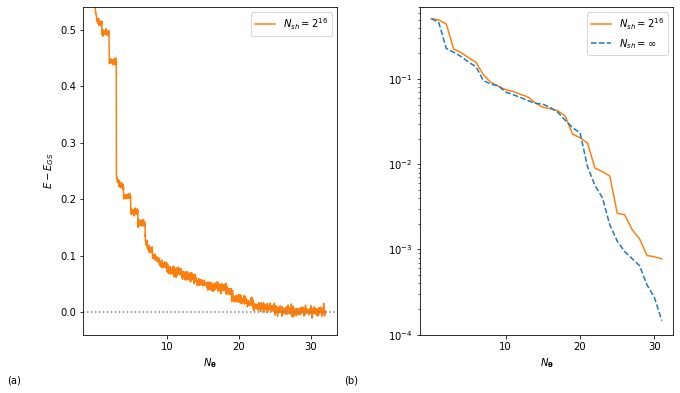

In [15]:
import numpy
import matplotlib.pyplot as plt

import matplotlib as mpl
c1 = mpl.rcParams['axes.prop_cycle']._left[1]['color']
c3 = mpl.rcParams['axes.prop_cycle']._left[0]['color']
xs = list(range(len(E_qasm)))
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(9.5, 5.5))
axs[0].plot(numpy.array(xs)/50, E_qasm-Eg, color=c1, label=r'$N_{sh}=2^{16}$')
axs[0].axhline(y=0., color='gray', linestyle=':')
#axs[0].set_xticks(ticks[1][9::10])
axs[0].set_xticks([10, 20, 30])

axs[0].set_ylim(-0.04, 0.54)
axs[0].set_ylabel(r'$E-E_{GS}$')
axs[0].set_xlabel(r'$N_{\mathbf{\theta}}$')
axs[0].legend()
axs[1].set_xlabel(r'$N_{\mathbf{\theta}}$')



xs2 = list(range(len(E_sv1)))
axs[1].set_yscale("log")
labels = [r'$N_{sh}=2^{16}$']
axs[1].plot(xs2[:-1], E_sv2-Eg, label=labels[0],color=c1)
axs[1].plot(xs2[:-1], E_sv1[:-1]-Eg, '--', label=r'$N_{sh}=\infty$',color=c3)
axs[1].set_xticks([10, 20, 30])
axs[1].legend()
axs[1].set_ylim(1e-4, 0.7)

for i, label in enumerate(['(a)', '(b)']):
    axs[i].text(-0.3, -0.15, label, transform=axs[i].transAxes,fontsize=10)
plt.tight_layout()

plt.show()
fig.savefig('Adadelta1.pdf')


In [ ]:
ParamsArr[-1]

In [168]:
qubitH_op=qubitOp(h1_D+h1_X,h2_D+h2_X)

In [172]:
from qiskit.opflow import I,X,Y,Z,StateFn,AbelianGrouper
from qiskit.utils import QuantumInstance
from qiskit.opflow import PauliExpectation, CircuitSampler, CircuitStateFn 
qc=var_form_base.construct_circuit(parameters=ParamsArr[-1])
psi = CircuitStateFn(qc)
# define the state to sample
measurable_expression = StateFn(qubitH_op, is_measurement=True).compose(psi) 
# convert to expectation value
expectation = PauliExpectation(group_paulis=True).convert(measurable_expression) 
sampler = CircuitSampler(QuantumInstance(backend,shots=2**16*3)).convert(expectation)
#var=PauliExpectation().compute_variance(sampler)/num_shots
O_sampled=sampler.eval()

In [187]:
AbelianGrouper().convert(measurable_expression)

ComposedOp([OperatorStateFn(SummedOp([PauliSumOp(SparsePauliOp(['IZXIZX', 'IZXIIX', 'IIXIZX', 'IIXIIX', 'IZIIII', 'ZZIIII', 'IIIIZI', 'IIIZZI', 'ZIIIII', 'IIIZII', 'IIIIII'],
              coeffs=[  0.525     -5.55111512e-17j,  -0.525     +5.55111512e-17j,
  -0.525     +0.00000000e+00j,   0.525     +0.00000000e+00j,
   0.175     +1.38777878e-17j,  -0.16165052+0.00000000e+00j,
   0.175     +0.00000000e+00j,  -0.16165052+0.00000000e+00j,
  -0.16165052+0.00000000e+00j,  -0.16165052+0.00000000e+00j,
 -13.65939792+0.00000000e+00j]), coeff=1.0), PauliSumOp(SparsePauliOp(['IYYIII', 'IIIIYY', 'YYIIII', 'IIIYYI'],
              coeffs=[0.15081297+0.j, 0.15081297+0.j, 0.15081297+0.j, 0.15081297+0.j]), coeff=1.0), PauliSumOp(SparsePauliOp(['XXZIII', 'IIIXXZ', 'IIZIIZ', 'IIZIII', 'IIIIIZ'],
              coeffs=[0.15081297+0.00000000e+00j, 0.15081297+1.38777878e-17j,
 1.75      +0.00000000e+00j, 2.264     +0.00000000e+00j,
 2.264     +0.00000000e+00j]), coeff=1.0), PauliSumOp(SparsePauliOp(['ZXXII